# Predição de Consumo de Combustível

Criação de modelos de aprendizado supervisionado para predizer o consumo de combustível de carros.

## Imports

É importante notar que boa parte do programa foi encapsulado em outros arquivos que são importados nesta seção do código.

In [46]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import preprocessing as pre
import plots as pl
import model_evaluation as me

## Análise Exploratória dos Dados

Aqui foi realizado o carregamento dos dados originais de um arquivo _csv_.

In [47]:
original_df = pd.read_csv('data/car_data_original.csv')

Com esses dados, realizou-se a construção de diversos gráficos de distribuições e correlações para analisar o que é interessante de ser realizado em relação aos atributos preditores na etapa de pré-processamento. Primeiramente, construiu-se um _violin plot_ comparando o consumo médio de combustível por quantidade de instâncias.

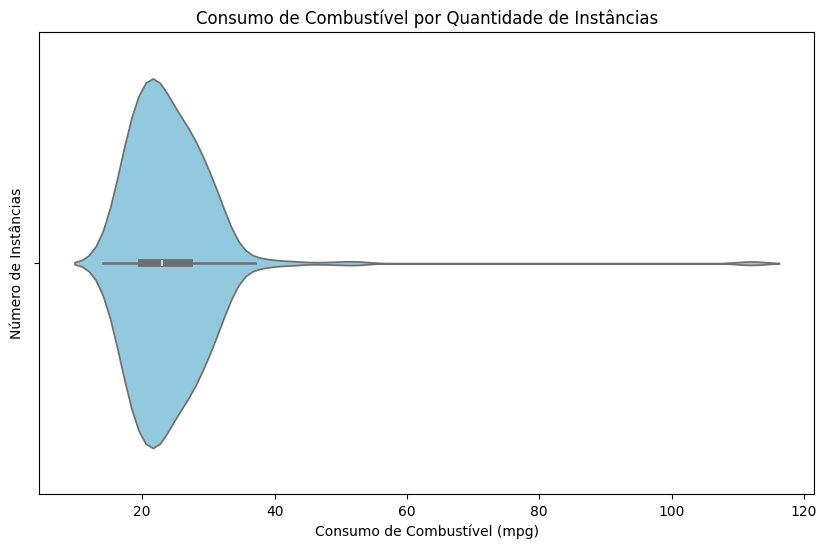

In [48]:
pl.plot_violinplot(original_df,
                  'combination_mpg',
                  'Consumo de Combustível por Quantidade de Instâncias',
                  'Consumo de Combustível (mpg)',
                  'pure_combination_mpg')

Nesse ponto, já se observa que há instâncias problemáticas, claramente _outliers_ que devem ser removidas do conjunto de dados. Ademais, a maior concentração dos veículos apresenta consumo médio entre 15 e 30mpg, algo que pode guiar bastante os modelos.

Após isso, analisou-se o atributo de classes de veículos para ter uma ideia da sua distribuição em um gráfico de setores.

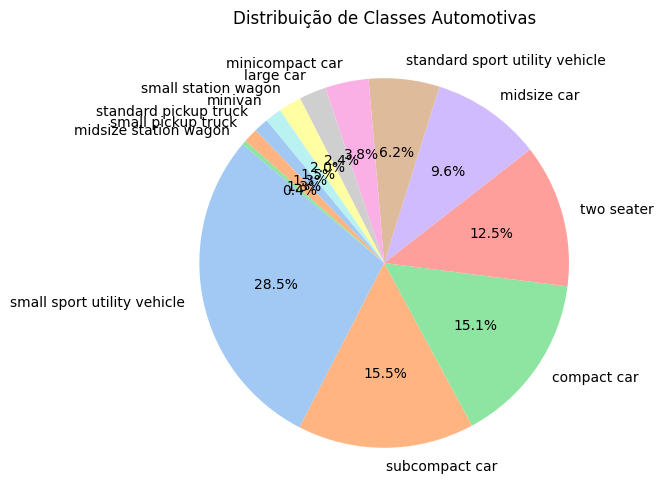

In [49]:
pl.plot_piechart(original_df,
                 'class',
                 'Distribuição de Classes Automotivas',
                 'pure_car_classes')

Com ele, é perceptível que talvez seja necessário agrupar as classes de veículos e outros atributos que contenham classes com muito poucos representantes, como _midsize station wagon_, por exemplo, em uma classe geral chamada _others_. Porém, essa discussão será retomada nas seções posteriores do relatório.

Por fim, analisou-se a Correlação de Pearson entre os atributos numéricos através do _heatmap_ abaixo:

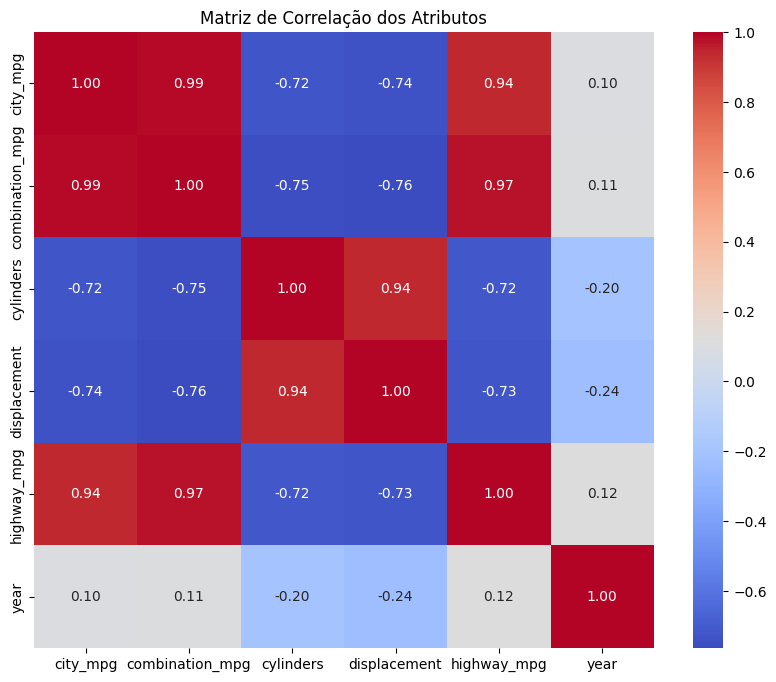

In [50]:
pl.plot_corr_heatmap(original_df,
                     'Matriz de Correlação dos Atributos',
                     'numeric_atributes_correlation')

Olhando para o gráfico acima, percebe-se que há diversos atributos preditores que apresentam alto nível de correlação com a saída _combination mpg_ e entre si. Ambos os atributos _highway mpg_ e _city mpg_ serão descartados do _dataset_ por terem alta correlação entre si e com o valor da saída do modelo, facilitando demais a tarefa dos modelos. Além disso, observa-se que _displacement_ e _cylinders_ também apresentam alta correlação entre si. No entanto, a informação de _cylinders_ ou cilindros de um carro é diferente da informação de _displacement_ ou cilindradas desse. As cilindradas representam o volume total dos cilindros de um motor. Por conta disso, são calculados a partir dos cilindros, porém acrescentam um dado a novo ao problema. Ou seja, vale a pena mesmo assim manter ambos os atributos no _dataset_.

## Pré-processamento dos Dados

Após a etapa de análise dos dados, realizou-se a remoção das instâncias de carros elétricos pois continham muitos atributos faltantes e removeu-se os atributos colineares citados na seção acima. Além disso, realizou-se uma limpeza dos _outliers_ restantes.

In [51]:
# Removendo os atributos colineares
no_colinear_df = pre.drop_atributes(original_df, ['highway_mpg', 'city_mpg'])

# Removendo as instâncias com NaN
no_nan_df = pre.remove_instances_with_nan(no_colinear_df)

no_outliers_df = pre.remove_outliers(no_nan_df, ['combination_mpg'])

Separou-se os atributos preditores `X` e preditos `y` em seguida.

In [52]:
X_pure = no_outliers_df.drop(columns=["combination_mpg"])
y_pure = no_outliers_df["combination_mpg"]

Após a separação, colocou-se ao menos uma instância de cada categoria no _dataset_ de treinamento/validação.

Como não há nenhuma garantia que pelo menos uma instância de cada tipo estará na etapa de testes, garantiu-se que pelo menos na parte de treinamento os modelos passariam por todos os tipos de modelos de carros, garantindo preditores treinados com mais completude.

In [53]:
train_indices = set()
categorical_features = X_pure.select_dtypes(include=['object', 'bool']).columns
for feature in categorical_features:
    unique_values = X_pure[feature].unique()
    for value in unique_values:
        index = X_pure[X_pure[feature] == value].index[0]
        train_indices.add(index)

train_indices = list(train_indices)
X_train_mandatory = X_pure.loc[train_indices]
y_train_mandatory = y_pure.loc[train_indices]
X = X_pure.drop(train_indices)
y = y_pure.drop(train_indices)

## Divisão de Dados e _Spot-checking_ de Algoritmos Preditores

Separou-se o conjunto de teste do conjunto de treinamento/validação antes de começar qualquer treinamento ou _spot-checking_ de modelos.

In [54]:
# Separação de dados de treinamento/teste
random_state = 42
test_proportion = 0.15
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_proportion, random_state=random_state)

Com essa separação, aplicou-se o treinamento e validação dos diversos modelos com a estratégia de _k-fold cross-validation_. Todos os modelos escolhidos abaixo foram configurados com os seus hiperparâmetros padrões. A normalização e a codificação dos dados é feita através do método `ColumnTransformer()` do _scikit learn_. Isso garante que, como são aplicadas a normalização por _min-max_ e a codificação _one-hot_ após a separação de teste e treinamento/validação, que não há vazamento de dados no processo. Nesta etapa, há a coleta dos dados necessários para comparar os modelos listados logo em seguida. Esses dados serão mostrados na próxima seção.

In [55]:
# Nomeação de todos os modelos a serem testados
methods = [
    "knn",
    "random_forest",
    "linear_regression",
    "neural_networks",
    "svm",
]

# Variáveis de controle para ajustar o número de iterações que calculam o desempenho e aumentam a reprodutibilidade dessa sequência de códigos
random_state = 42
kfolds = 13

# Variáveis utilizadas para a análise de resultados posteriormente
metrics = dict.fromkeys(methods, [])

for method in methods:
    # Utilização de k-fold cross-validation para avaliar cada modelo
    model_metrics = []
    kf = KFold(n_splits=kfolds)
    for train_indexes, val_indexes in kf.split(X_train):
        X_fold_train, X_fold_val, y_fold_train, y_fold_val = me.generate_train_validation_sets(train_indexes, val_indexes, 
                                                                                               X_train, X_train_mandatory,
                                                                                               y_train, y_train_mandatory)
        model_metric = me.evaluate_model(method,
                                         X_fold_train, X_fold_val,
                                         y_fold_train, y_fold_val,
                                         random_state)
        # Acúmulo das métricas de predição dos modelos
        model_metrics.append(model_metric)
    metrics[method] = model_metrics

## Sumarização e Avaliação dos Resultados

Com o _spot checking_ realizado acima, obteve-se o conjunto de métricas do _Mean Squared Error_ dos modelos. Optou-se por essa métrica pois os _outliers_ já foram removidos e essa converge mais rapidamente quando não há presença de muitos _outliers_.

Porém, antes de analisar os resultados dos modelos, avaliar-se-á como ficou a distribuição dos dados após as etapas de pré-processamento anterior.

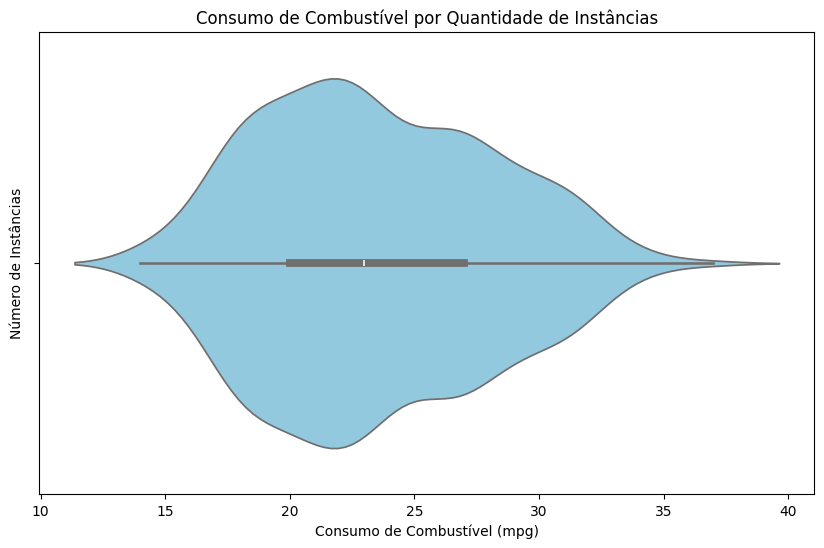

In [56]:
pl.plot_violinplot(no_outliers_df,
                  'combination_mpg',
                  'Consumo de Combustível por Quantidade de Instâncias',
                  'Consumo de Combustível (mpg)',
                  'no_outliers_combination_mpg')

Percebe-se que houve uma boa melhoria na distribuição dos dados de consumo de combustível com o pré-processamento aplicado anteriormente.

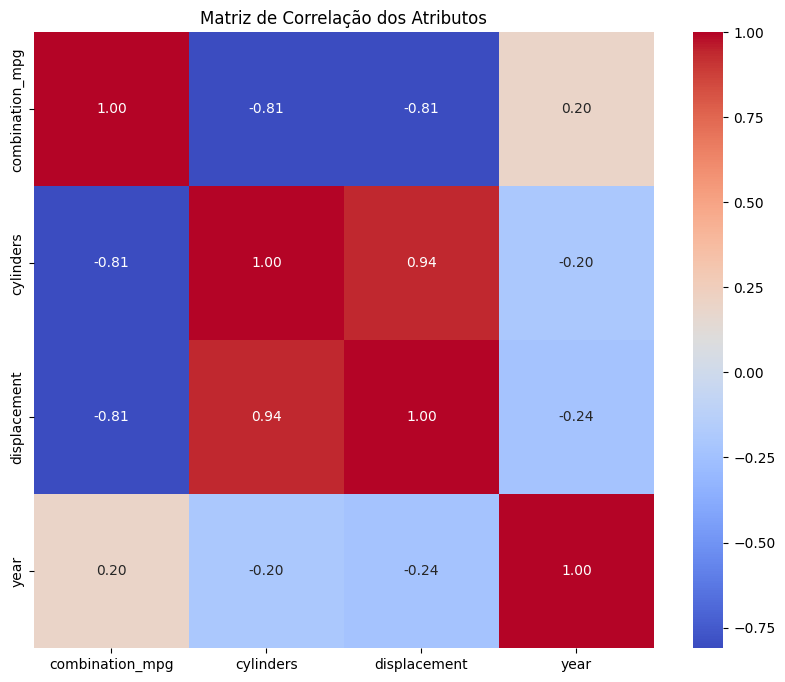

In [57]:
pl.plot_corr_heatmap(no_outliers_df,
                     'Matriz de Correlação dos Atributos',
                     'no_outliers_numeric_atributes_correlation')

Agora sim percebe-se que há bem menos correlação entre os dados numéricos mantidos no _dataset_ em comparação com anteriormente.

Sobre a questão do agrupamento de atributos categóricos muito esparsos, foi percebido que o desempenho já nesta etapa se tornou inferior quando aplicado o agrupamento em comparação com o desempenho atingido
sem a aplicação desse pré-processamento (resultados com média aproximada de 1,5 e desvio padrão 0,5 de MSE passaram a mostrar resultados de mais de 2,5 de média e desvio padrão de mais de 1). Por conta disso,
optou-se por não adotar essa técnica para este problema.

Por fim, seguem as análises dos modelos com _boxplots_, médias e desvios padrão:


Média dos MSE do modelo knn: 3.044112619406737.
Desvio padrão dos MSE do modelo knn: 1.3394597798391317.


Média dos MSE do modelo random_forest: 1.8041308337243736.
Desvio padrão dos MSE do modelo random_forest: 1.0448957241550794.


Média dos MSE do modelo linear_regression: 1.5499551363006885.
Desvio padrão dos MSE do modelo linear_regression: 0.5309921271918271.


Média dos MSE do modelo neural_networks: 1.1891684581719317.
Desvio padrão dos MSE do modelo neural_networks: 0.5090977137509275.


Média dos MSE do modelo svm: 4.196092331540937.
Desvio padrão dos MSE do modelo svm: 2.028466582439441.



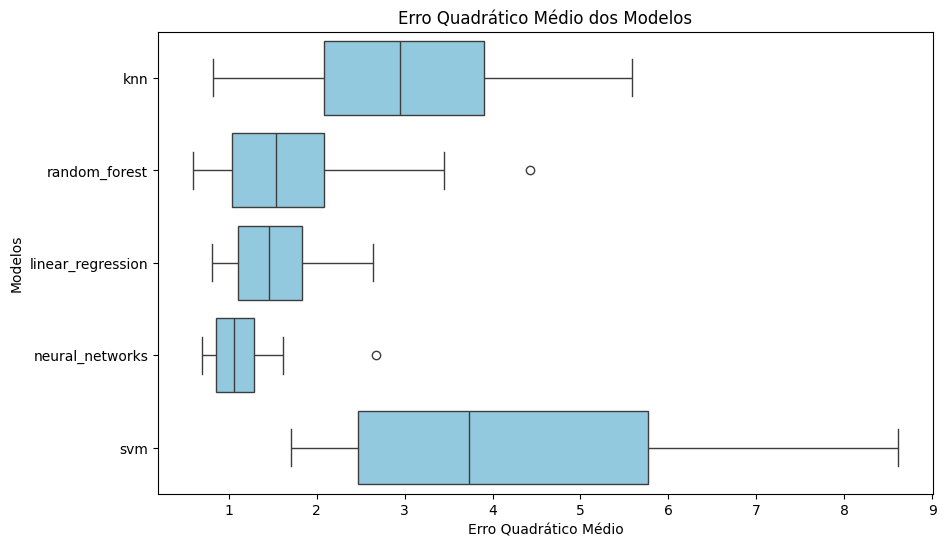

In [58]:
pl.plot_boxplot(metrics,
                'Erro Quadrático Médio dos Modelos',
                'Erro Quadrático Médio',
                'Modelos',
                'mse')

for method in methods:
    print(f'\nMédia dos MSE do modelo {method}: {np.average(metrics[method])}.')
    print(f'Desvio padrão dos MSE do modelo {method}: {np.std(metrics[method])}.\n')

Com esses resultados, mesmo que os resultados não sejam reproduzíveis exatamente com os mesmos valores a cada vez que o código é executado, fica claro que os 3 modelos mais promissores foram a __Floresta Aleatória__, a __Regressão Linear__ e as __Redes Neurais__. Como nenhum atributo foi otimizado, pode ser que os outros dois modelos se desempenhassem melhor, porém, com as configurações básicas de hiperparâmetros, esses foram os três mais promissores.

Dentre esses, fica claro que os mais eficientes nesta tarefa foram o algoritmo de Regressão Linear e o modelo de Redes Neurais, visto que os erros da Floresta Aleatória são mais elevados no geral quando comparado com esses últimos dois. Mesmo que as Redes Neurais apresentem média e desvio padrão melhores do que a Regressão Linear, o _box plot_ acima reforça que o viés do erro da Regressão Linear é um pouco mais concentrado, próximo de um valor estável para este teste. Por conta dessas razões, serão aprofundados as Florestas Aleatórias, o Regressor Linear e as Redes Neurais, com enfase nos últimos dois.

## Otimização de Hiperparâmetros

Utilizando os dados após a primeira etapa de pré-processamento para este estágio, realizou-se a reconstrução de um conjunto de treinamento mais simples para obter-se uma base de comparação entre os hiperparâmetros dos modelos:

In [59]:
X_opt = pd.concat([X_train, X_train_mandatory])
y_opt = pd.concat([y_train, y_train_mandatory])

Com os três modelos separados acima, será realizada a otimização dos seus hiperparâmetros. Como a Regressão Linear não apresenta nenhum hiperparâmetro relevante, essa não precisa ser otimizada. Já as Redes Neurais e a Floresta Aleatória devem ter seus hiperparâmetros avaliados. Para tanto, otimizar-se-á a quantidade de estimadores `n_estimators` e o valor de poda alfa `ccp_alpha` da Floresta Aleatória, e o `solver` e as camadas ocultas `hidden_layer_sizes` das Redes Neurais abaixo.

___O código a seguir levou mais de 6h para executar, por isso está comentado para evitar execuções desprevinidas.___

In [60]:
# Nomeação de todos os modelos a serem otimizados
methods = [
    "random_forest",
    "neural_networks",
]

# Variáveis de controle para ajustar o número de iterações que calculam o desempenho e aumentam a reprodutibilidade dessa sequência de códigos
random_state = 42
kfolds = 5 # Quantidade padrão da biblioteca

# Gera e imprime a melhor configuração de hiperparâmetros para cada modelo
# for method in methods:
#     best_param, best_score = me.optimize_hyperparameters(method, X_opt, y_opt, kfolds, random_state)
#     print(f'Para o modelo {method}:\n- Melhor hiperparâmetro: {best_param};\n- Pontuação: {best_score}.\n')

Ao executar o código acima, observou-se que o melhor desempenho para cada veio dos seguintes hiperparâmetros:

- Floresta Aleatória:
  - `n_estimators`: 400;
  - `ccp_alpha`: 0.0 (sem poda);
- Redes Neurais:
  - `solver`: L-BFGS;
  - `hidden_layer_sizes`: 25, 50, 25 neurônios de camadas ocultas.

## Analise dos Modelos Otimizados

Gerando os modelos finais com os hiperparâmetros otimizados.

In [64]:
randomForestRegressor = RandomForestRegressor(n_estimators=400, random_state=random_state)
linearRegressor = LinearRegression()
neuralNetworkRegressor = MLPRegressor(solver='lbfgs', hidden_layer_sizes=(25,50,25), max_iter=25000, random_state=random_state)

Treinando esses modelos de forma definitiva antes de testá-los no conjunto de teste para escolhermos o melhor modelo.

In [65]:
randomForestPipe = me.final_training(X_opt, y_opt, randomForestRegressor)
linearRegressionPipe = me.final_training(X_opt, y_opt, linearRegressor)
neuralNetworkPipe = me.final_training(X_opt, y_opt, neuralNetworkRegressor)

Testando os modelos no dataset de teste.

In [87]:
randomForest_prediction = randomForestPipe.predict(X_opt)
linearRegression_prediction = linearRegressionPipe.predict(X_opt)
neuralNetwork_prediction = neuralNetworkPipe.predict(X_opt)

randomForest_MSE_train = mean_squared_error(y_opt, randomForest_prediction)
linearRegression_MSE_train = mean_squared_error(y_opt, linearRegression_prediction)
neuralNetwork_MSE_train = mean_squared_error(y_opt, neuralNetwork_prediction)

print(f'Erro quadrático médio do modelo Regressor Floresta Aleatório durante o treinamento: {randomForest_MSE_train}')
print(f'Erro quadrático médio do modelo de Regressão Linear durante o treinamento: {linearRegression_MSE_train}')
print(f'Erro quadrático médio do modelo de Rede Neural (MLP) durante o treinamento: {neuralNetwork_MSE_train}')
print()

randomForest_prediction = randomForestPipe.predict(X_test)
linearRegression_prediction = linearRegressionPipe.predict(X_test)
neuralNetwork_prediction = neuralNetworkPipe.predict(X_test)

randomForest_MSE_test = mean_squared_error(y_test, randomForest_prediction)
linearRegression_MSE_test = mean_squared_error(y_test, linearRegression_prediction)
neuralNetwork_MSE_test = mean_squared_error(y_test, neuralNetwork_prediction)

print(f'Erro quadrático médio do modelo Regressor Floresta Aleatório no teste: {randomForest_MSE_test}')
print(f'Erro quadrático médio do modelo de Regressão Linear no teste: {linearRegression_MSE_test}')
print(f'Erro quadrático médio do modelo de Rede Neural (MLP) no teste: {neuralNetwork_MSE_test}')
print()

encoder = OneHotEncoder(handle_unknown='infrequent_if_exist')
X_encoded = encoder.fit_transform(X_opt[categorical_features])
print(encoder.categories_)
#print(X_encoded.todense())

coefficients = pd.concat([pd.DataFrame(X_opt.columns),pd.DataFrame(np.transpose(linearRegressor.coef_))], axis = 1)
print(linearRegressor.coef_)


Erro quadrático médio do modelo Regressor Floresta Aleatório durante o treinamento: 0.3137358378228253
Erro quadrático médio do modelo de Regressão Linear durante o treinamento: 0.4536252693141651
Erro quadrático médio do modelo de Rede Neural (MLP) durante o treinamento: 0.0303311681938178

Erro quadrático médio do modelo Regressor Floresta Aleatório no teste: 1.878812906334689
Erro quadrático médio do modelo de Regressão Linear no teste: 1.6110913495710684
Erro quadrático médio do modelo de Rede Neural (MLP) no teste: 2.397267971209571
[array(['compact car', 'large car', 'midsize car', 'midsize station wagon',
       'minicompact car', 'minivan', 'small pickup truck',
       'small sport utility vehicle', 'small station wagon',
       'standard pickup truck', 'standard sport utility vehicle',
       'subcompact car', 'two seater'], dtype=object), array(['4wd', 'awd', 'fwd', 'rwd'], dtype=object), array(['diesel', 'gas'], dtype=object), array(['acura', 'aston martin', 'audi', 'bentley